#Dados de nomes em Security Cards
https://catalog.data.gov/dataset/baby-names-from-social-security-card-applications-national-data

In [2]:
# from google.cloud import bigquery
# client = bigquery.Client()

# sql = """
# SELECT
#   name,
#   gender,
#   COUNT(name) AS num_names
# FROM
#   `bigquery-public-data.usa_names.usa_1910_current`
# GROUP BY
#   name,
#   gender
# """

# names_df = client.query(sql).to_dataframe()

# print(names_df.shape)
# names_df.head()

### Data Loading

In [114]:
import pandas as pd
import numpy as np

import unicodedata
import string
import random

from metaphone import doublemetaphone

from sklearn.model_selection import train_test_split

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    all_letters = string.ascii_letters + " .,;'"
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

MAX_CHAR = 4
NEUTRAL_NAMES = False
NAME_COUNT_THRESHOLD = 5

model_df = pd.read_csv("data/bigquery-results/bq-results-20220101-122926-phn99u10bjpw.csv")
model_df['ascii_name'] = [unicodeToAscii(name) for name in model_df['name']]
model_df['lowascii_name'] = model_df['ascii_name'].str.lower()

model_df['bound_lowascii_name'] = (MAX_CHAR-1)*'_' + model_df['lowascii_name'] + '_'*(MAX_CHAR-1) #grande acrescimo a performance
model_df['meta_bound_lowascii_name'] = model_df['bound_lowascii_name'] + ' ' + (MAX_CHAR-1)*'_' + model_df['bound_lowascii_name'].apply(lambda x: doublemetaphone(x)[0]) + '_'*(MAX_CHAR-1)

#incorporating total_name_count to see possible neutral names and filtering
model_df = model_df.merge(
    model_df[['name','count_name']].rename(columns={'count_name':'name_total_count'}).groupby('name', as_index=False).sum(),
    how='inner',on='name')
model_df['perc_name_tc'] = 1 - (model_df['name_total_count'] - model_df['count_name'])/model_df['name_total_count']

#filter for names
model_df = model_df[model_df['name_total_count'] >= NAME_COUNT_THRESHOLD]

if NEUTRAL_NAMES:
    #creating neutral scores for names
    model_df['neutral_score'] = - (model_df['perc_name_tc'] - 0.5)**2
    model_df = model_df.sort_values(by='neutral_score', ascending=True)
else:
    model_df = model_df.sort_values(by='count_name',ascending=False).drop_duplicates(subset='name', keep='first')


model_df = model_df.sample(len(model_df))

# Step 2: Split Training and Test Data
X = model_df.drop(['gender'],axis=1)
y = np.asarray(model_df['gender'].values.tolist())

X_train_df, X_test_df, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0)

## Approach 1 - Classical NLP

In [148]:
#### import pandas as pd
import enchant
from metaphone import doublemetaphone

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import CategoricalNB,BaseNB,BernoulliNB, MultinomialNB, GaussianNB
from sklearn.svm import LinearSVC,SVC
from sklearn.metrics import classification_report

MAX_CHAR = 4

X_train = X_train_df['lowascii_name']
X_test = X_test_df['lowascii_name']

vect = CountVectorizer(analyzer='char', ngram_range=(1,MAX_CHAR))
#vect = grid_search.best_estimator_['vectorizer']
X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

model = LinearSVC(dual=True)
#model = grid_search.best_estimator_['model']

model.fit(X_train_vect, y_train)
y_pred = model.predict(X_test_vect)

print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           F       0.90      0.90      0.90      2356
           M       0.84      0.85      0.84      1522

    accuracy                           0.88      3878
   macro avg       0.87      0.87      0.87      3878
weighted avg       0.88      0.88      0.88      3878



## Approach 2 - Deep Learning

In [149]:
import torch
import torch.nn as nn

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def df2dict(df,key_col,val_col):
    
    final_dict = {}
    for key in df[key_col].unique():
        final_dict.update({key : df[df[key_col] == key][val_col].tolist()})
        
    return final_dict

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print('Unicode to ASCII:',unicodeToAscii('Ślusàrski'))
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
all_categories = ['F', 'M']
n_categories = len(all_categories)

print(letterToTensor('J'))
print(letterToTensor('J').argmax())
print(lineToTensor('Jones').size())

Unicode to ASCII: Slusarski
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
tensor(35)
torch.Size([5, 1, 57])


In [150]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [151]:
input = lineToTensor('tom')
hidden = rnn.initHidden()

for charTensor in input:
    print('CharTensor:\n',charTensor)
    print('HiddenValue:\n',hidden)
    print('\n'*2)
    output, hidden = rnn(charTensor,hidden)
    
print(output)

CharTensor:
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
HiddenValue:
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]])



CharTensor:
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0

In [152]:
train_df = pd.concat([X_train_df.reset_index(drop=True), 
           pd.Series(y_train,name='gender')],axis=1)

category_lines = df2dict(df=train_df, key_col='gender', val_col='lowascii_name')

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = F / line = adi
category = F / line = zola
category = F / line = teena
category = F / line = lucetta
category = M / line = aedyn
category = M / line = quinlan
category = M / line = haakon
category = M / line = keegan
category = F / line = midge
category = M / line = rozell


In [153]:
def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

def returnTrainingExample(idx, X=X_train.tolist(), y=y_train.tolist()):
    
    assert isinstance(X_train,(list,pd.Series))
    category = y[idx]
    line = X[idx]
    line_tensor = lineToTensor(line)
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    return category, line, category_tensor, line_tensor

In [154]:
import time
import math

def train():
    hidden = rnn.initHidden()

    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()


criterion = nn.NLLLoss()
learning_rate = 0.0010 # If you set this too high, it might explode. If too low, it might not learn
n_iters = 100000
print_every = 5000
plot_every = 100

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    X=X_train.tolist()
    y=y_train.tolist()
    idx = iter % len(X)
    category, line, category_tensor, line_tensor = returnTrainingExample(idx, X=X, y=y)
    output, loss = train()
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
    if iter % len(X_train)== 0:
        print(f'\n ===== {iter / len(X_train)} Epoch Finished','='*30,'\n')

5000 5% (0m 12s) 0.5801 maris / F ✓
10000 10% (0m 24s) 0.4192 keilany / F ✓
15000 15% (0m 38s) 0.5502 rashaud / M ✓

 ===== 1.0 Epoch Finished ============================== 

20000 20% (0m 57s) 0.8363 cove / F ✗ (M)
25000 25% (1m 17s) 1.3106 yale / F ✗ (M)
30000 30% (1m 34s) 0.2222 radha / F ✓

 ===== 2.0 Epoch Finished ============================== 

35000 35% (1m 50s) 0.0928 jaquita / F ✓
40000 40% (2m 6s) 1.2956 isayah / F ✗ (M)
45000 45% (2m 32s) 0.4595 marshae / F ✓

 ===== 3.0 Epoch Finished ============================== 

50000 50% (2m 49s) 0.3307 jaleah / F ✓
55000 55% (3m 12s) 0.8071 cordie / M ✗ (F)
60000 60% (3m 29s) 1.1623 jann / M ✗ (F)

 ===== 4.0 Epoch Finished ============================== 

65000 65% (3m 47s) 0.0554 kaitlynne / F ✓
70000 70% (4m 7s) 0.9169 dashay / M ✗ (F)
75000 75% (4m 22s) 0.3618 shiv / M ✓

 ===== 5.0 Epoch Finished ============================== 

80000 80% (4m 38s) 0.1251 tashaun / M ✓
85000 85% (4m 52s) 0.1490 montavious / M ✓
90000 90% (5m 7

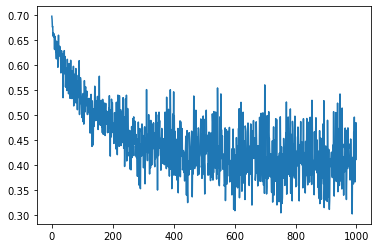

In [156]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.plot(all_losses)

In [157]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

print('Lucas', evaluate(lineToTensor('Lucas')))

X=X_test.tolist()
y=y_test.tolist()

y_pred = []
for idx in range(len(X)):
    category, line, category_tensor, line_tensor = returnTrainingExample(idx, X=X, y=y)
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    y_pred.append(guess)

Lucas tensor([[-2.3903, -0.0961]], grad_fn=<LogSoftmaxBackward>)


In [159]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           F       0.85      0.84      0.85      2356
           M       0.76      0.78      0.77      1522

    accuracy                           0.82      3878
   macro avg       0.81      0.81      0.81      3878
weighted avg       0.82      0.82      0.82      3878



In [168]:
EMBEDDING_DIM = 64
HIDDEN_DIM = 64
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size=len(all_letters), output_size=2):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, output_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [169]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM)

In [172]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.1)
criterion = nn.NLLLoss()

In [173]:
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)
    print(tag_scores)

for epoch in range(300):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in training_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

# See what the scores are after training
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)

    # The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
    # for word i. The predicted tag is the maximum scoring tag.
    # Here, we can see the predicted sequence below is 0 1 2 0 1
    # since 0 is index of the maximum value of row 1,
    # 1 is the index of maximum value of row 2, etc.
    # Which is DET NOUN VERB DET NOUN, the correct sequence!
    print(tag_scores)

NameError: name 'prepare_sequence' is not defined